# Открытие и просмотр данных

В данном проекте, стоит задача разработать модель, которая будет предсказывать стоимость автомобилей на вторичном рынке на основании массива представленных данных.

 Этапы разработки проекта:
* загрузка и ознакомление с данными;
* предварительная обработка;
* полноценный разведочный анализ;
* разработка новых синтетических признаков;
* проверка на мультиколлинеарность;
* отбор финального набора обучающих признаков;
* выбор и обучение моделей;
* итоговая оценка качества предсказания лучшей модели.

**В данном проекте работаем с линейной регрессией, а для оценки качества подобных моделей будем использовать метрику `MAPE - mean absolute percentage error` (cредняя абсолютная процентная ошибка). Поиск лучшей модели будем производить по кросс-валидации.**

## Значения  столбцов

## Открытие файлов данных

### Подгружаем нужные библиотеки

In [1]:
# Вызываем основные библиотеки
import pandas as pd
import numpy as np

# Вызываем библеотеку содержащую метрику, которая будет оценивать качество моделей
from sklearn.metrics import mean_absolute_error

# Вызываем метод, необходимый для разделения данных
from sklearn.model_selection import train_test_split

# Вызываем метрку для оценки качества модели
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Вызываем дополнительные библиотеки
from math import ceil # для округления в большую сторону
from sklearn.utils import shuffle # для распределения данных в случайном порядке
import matplotlib.pyplot as plt # для построения диаграмм
import random # для случайного подбора параметров

# Уберём мешающие предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Из-за того, что методы sklearn не подошли по причине необходимости задействовать свыше 50 GB RAM
# для преообразования массива при кодировании, будем использовать возможности библиотеки CatBoost
from catboost import CatBoostRegressor, CatBoostRanker # вызываем методы для регрессии и случайного леса
from catboost import cv, Pool

In [3]:
# Вызываем библиотеки содержащие необходимые модели
#from sklearn.linear_model import LinearRegression
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor

# Вызываем библеотеку, позволяющую использовать кроссвалидацию для оценки качества моделей
#from sklearn.model_selection import cross_val_score

# Добавим возможность масштабировать и кодировать признаки
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OrdinalEncoder
#from sklearn.preprocessing import OneHotEncoder

### Смотрим на наши данные

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
display(train.head())
display(test.head())

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [6]:
train.info()
print()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 11005

# Предобработка данных

### Изучаем есть ли лишние столбцы

**Так как ВИН автомобиля является уникальным для каждого авто, то его можно исключить. Сделаем быструю проверку на уникальность и затем удалим данный столбец.**

In [7]:
print(train['vin'].value_counts())
print(test['vin'].value_counts())

2fmdk4kc8cba21686    1
wddgf4hb0da792893    1
1fmeu73ex8ua42928    1
1gcjk33234f260263    1
2hnyd2h63bh521055    1
                    ..
1n4al21e17n490565    1
2g1wb58k881206926    1
1zvbp8em0e5231700    1
3n1ab61e58l734646    1
1g4gc5e36df178984    1
Name: vin, Length: 440236, dtype: int64
1fmeu7f8xaua10265    1
3c4pdcbg0ft552026    1
3gnec16z95g253692    1
jteep21a670203467    1
5gzcz53bx3s878247    1
                    ..
4t1bf3ek1bu206115    1
5n1al0mm2ec507816    1
3vwd17aj6em396371    1
wddgf4hb9dr269387    1
wp0ab29846u783859    1
Name: vin, Length: 110058, dtype: int64


***Все Вин-номеря уникальны, потому просто удалим данный столбец.***

In [8]:
# Перед удалением сохраним тестовые вины в массив, чтобы потом на их использовать результатах.
vins_arr = test['vin']
# теперь удалим вины из фреймов
train = train.drop(['vin'], axis=1)
test = test.drop(['vin'], axis=1)

display(train.head())
display(test.head())

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


### Изучим стоимость авто

In [9]:
np.sort(train['sellingprice'].unique())

array([     1,    100,    125, ..., 173000, 183000, 230000], dtype=int64)

In [10]:
for price in np.sort(train['sellingprice'].unique())[:10]:
    print(price)

1
100
125
150
175
200
225
250
275
300


***Как видно, в массиве присутствует нереально низкая стоимость автомобилей, что не очень хорошо. Однако, у нас нет информации о том, насколько сильно "загрязнены" данные в тесте, т.к. там нет этого поля. Из-за этого, не будем ничего менять в обучающих данных, а вдруг подобные значения есть и в тесте.***

In [11]:
train['condition'].unique()

array([4.2, 3.5, 2.2, 2.8, 2. , 2.5, 3.4, 4.8, 1.9, 1. , 3.1, 2.7, 3.6,
       2.9, 4.1, 2.6, 2.1, 3. , 4.9, 4.7, 4. , 3.3, 3.8, 3.7, 4.5, 4.6,
       5. , 4.3, 2.4, 2.3, 3.9, nan, 3.2, 4.4, 1.4, 1.5, 1.7, 1.2, 1.3,
       1.6, 1.8, 1.1])

### Просмотр данных на наличие пропусков

In [12]:
print(train.isna().sum())
print()
print(test.isna().sum())

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13011
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64


***Как видно, пропуски имеем практически везде.***

#### Посмотрим на пропуски

In [13]:
display(train[train['make'].isna() == True])

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate
10,2007,NaN,NaN,NaN,NaN,automatic,ca,3.1,102507.0,blue,gray,aaero sweet company,17250,Thu Jan 29 2015 03:30:00 GMT-0800 (PST)
42,2007,NaN,NaN,NaN,NaN,manual,md,2.8,92656.0,blue,gray,credit acceptance corp/vrs/southfield,5600,Tue Jun 16 2015 02:30:00 GMT-0700 (PDT)
63,2011,NaN,NaN,NaN,NaN,automatic,ga,5.0,67159.0,white,gray,"vpsi, inc",13200,Thu Jun 04 2015 03:00:00 GMT-0700 (PDT)
64,2008,NaN,NaN,NaN,NaN,automatic,ca,4.1,113582.0,white,gray,wholesale motor sales inc,4100,Thu Feb 05 2015 04:00:00 GMT-0800 (PST)
111,2006,NaN,NaN,NaN,NaN,automatic,nv,2.8,129019.0,orange,gray,credit acceptance corp/vrs/southfield,2900,Thu Feb 05 2015 04:00:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440085,2011,NaN,NaN,NaN,NaN,automatic,az,3.5,80594.0,white,gray,mike albert fleet solutions,11100,Wed Feb 04 2015 03:00:00 GMT-0800 (PST)
440114,2011,NaN,NaN,NaN,NaN,automatic,nj,3.5,134164.0,—,black,merchants automotive group,11800,Wed Mar 04 2015 01:30:00 GMT-0800 (PST)
440118,2004,NaN,NaN,NaN,NaN,automatic,md,3.5,123123.0,white,beige,credit acceptance corp/vrs/southfield,3400,Tue Feb 17 2015 01:30:00 GMT-0800 (PST)
440122,2007,NaN,NaN,NaN,NaN,automatic,ca,2.5,39545.0,black,black,hornburg jaguar,17750,Wed Jun 17 2015 05:15:00 GMT-0700 (PDT)


In [14]:
display(test[test['make'].isna() == True])

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate
22,2006,NaN,NaN,NaN,NaN,automatic,pa,2.4,143377.0,blue,gray,ryan mtrs of morristown inc,Fri Jan 23 2015 01:00:00 GMT-0800 (PST)
72,2000,NaN,NaN,NaN,NaN,manual,mo,NaN,76674.0,black,—,effingham auto care & tire inc,Mon Dec 22 2014 11:00:00 GMT-0800 (PST)
220,2003,NaN,NaN,NaN,NaN,automatic,tx,4.9,107337.0,silver,gray,fairway ford henderson,Wed Feb 18 2015 02:00:00 GMT-0800 (PST)
237,1998,NaN,NaN,NaN,NaN,automatic,nv,2.0,243163.0,gray,—,titlemax/las vegas nv32,Thu Feb 19 2015 03:00:00 GMT-0800 (PST)
287,2009,NaN,NaN,NaN,NaN,automatic,pa,2.1,179884.0,white,gray,lease plan usa,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109622,2007,NaN,NaN,NaN,NaN,automatic,wa,2.0,133227.0,blue,beige,primus automotive financial services,Wed Feb 11 2015 04:35:00 GMT-0800 (PST)
109665,2010,NaN,NaN,NaN,NaN,automatic,fl,2.9,69783.0,black,gray,premier partners inc.,Thu Jan 15 2015 02:30:00 GMT-0800 (PST)
109717,1999,NaN,NaN,NaN,NaN,automatic,pa,3.7,179570.0,white,blue,ari,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
109948,2006,NaN,NaN,NaN,NaN,automatic,md,3.2,107466.0,white,beige,wells fargo dealer services,Tue May 26 2015 02:30:00 GMT-0700 (PDT)


In [15]:
train[train['make'].isna() == True].isna().sum()

year               0
make            8043
model           8043
trim            8043
body            8043
transmission    1386
state              0
condition         66
odometer           2
color             14
interior          14
seller             0
sellingprice       0
saledate           0
dtype: int64

In [16]:
test[test['make'].isna() == True].isna().sum()

year               0
make            2061
model           2061
trim            2061
body            2061
transmission     354
state              0
condition         21
odometer           1
color              1
interior           1
seller             0
saledate           0
dtype: int64

***Исходя из сделанной проверки, можем сделать вывод, что в большинстве случаев, если не указана марка авто, то будет не указана модель, тип кузова и модификация. Проставим в данных столбцах вместо пропусков значение "unknown". Кроме того, имеем пропуски также и в столбцах посвященных цветам кузова и интерьера, данные параметры имеют не значительный вес на вторичном рынке, потому его тоже просто заменим на "unknown".***

#### Пропуски в категориальных признаках

**Производим замену пустых значиний на "unknown", так где это точно стоит сделать. Кроме того, ввиду того, что инфо по трансмиссиям мы получить чисто технически не можем, то эти поля также заменим на значение "unknown".**

In [17]:
# Уберем пропуски в цикле
for row in ['make', 'model', 'trim', 'body', 'color', 'interior', 'transmission']:
    train[row] = train[row].fillna('unknown')
    test[row] = test[row].fillna('unknown')

In [18]:
# Проверка
print(train.isna().sum())
print(test.isna().sum())

year               0
make               0
model              0
trim               0
body               0
transmission       0
state              0
condition       9405
odometer          69
color              0
interior           0
seller             0
sellingprice       0
saledate           0
dtype: int64
year               0
make               0
model              0
trim               0
body               0
transmission       0
state              0
condition       2379
odometer          19
color              0
interior           0
seller             0
saledate           0
dtype: int64


#### Пробег и состояние автомобилей

**Пробег и состояние авто будем заменять медианными значениями по сгруппированным данным. Группировать будем по году, затем по модели авто, т.к. год - это вообще как главный показатель, а модель - потому что дорогой автомобиль даже старый может иметь как лучший вид так и меньший пробег, плюс за дорогим авто и ухаживать будут лучше, нежели за бюджетным. Потому делать будем именно такую группировку.**

In [19]:
# Соберём медианные значения
pivot_train = train.pivot_table(index='year', columns='model', values=['odometer', 'condition'], aggfunc='median')
pivot_test = test.pivot_table(index='year', columns='model', values=['odometer', 'condition'], aggfunc='median')

In [20]:
display(pivot_train.head(10))

condition                                                      \
model  1 Series 1500 190-Class 2 Series 200 200SX 2500   3 3 Series   
year                                                                  
1982        NaN  NaN       NaN      NaN NaN   NaN  NaN NaN      NaN   
1983        NaN  NaN       NaN      NaN NaN   NaN  NaN NaN      NaN   
1984        NaN  NaN       NaN      NaN NaN   NaN  NaN NaN      NaN   
1985        NaN  NaN       NaN      NaN NaN   NaN  NaN NaN      NaN   
1986        NaN  NaN       NaN      NaN NaN   NaN  NaN NaN      NaN   
1987        NaN  NaN       NaN      NaN NaN   NaN  NaN NaN      NaN   
1988        NaN  NaN       NaN      NaN NaN   NaN  NaN NaN      NaN   
1989        NaN  NaN       NaN      NaN NaN   NaN  NaN NaN      NaN   
1990        NaN  NaN       NaN      NaN NaN   NaN  NaN NaN      NaN   
1991        NaN  NaN       NaN      NaN NaN   NaN  NaN NaN      NaN   

                             ... odometer                                     \
model 3 Series Gran Turismo  ...  voyager wave windstar wrangler x-trail  xA   
year                         ...                                               
1982                    NaN  ...      NaN  NaN      NaN      NaN     NaN NaN   
1983                    NaN  ...      NaN  NaN      NaN      NaN     NaN NaN   
1984                    NaN  ...      NaN  NaN      NaN      NaN     NaN NaN   
1985                    NaN  ...      NaN  NaN      NaN      NaN     NaN NaN   
1986                    NaN  ...      NaN  NaN      NaN      NaN     NaN NaN   
1987                    NaN  ...      NaN  NaN      NaN      NaN     NaN NaN   
1988                    NaN  ...      NaN  NaN      NaN      NaN     NaN NaN   
1989                    NaN  ...      NaN  NaN      NaN      NaN     NaN NaN   
1990                    NaN  ...      NaN  NaN      NaN      NaN     NaN NaN   
1991                    NaN  ...      NaN  NaN      NaN      NaN     NaN NaN   

                           
model  xB  xD yaris yukon  
year                       
1982  NaN NaN   NaN   NaN  
1983  NaN NaN   NaN   NaN  
1984  NaN NaN   NaN   NaN  
1985  NaN NaN   NaN   NaN  
1986  NaN NaN   NaN   NaN  
1987  NaN NaN   NaN   NaN  
1988  NaN NaN   NaN   NaN  
1989  NaN NaN   NaN   NaN  
1990  NaN NaN   NaN   NaN  
1991  NaN NaN   NaN   NaN  

[10 rows x 1905 columns]

##### Обучающие данные

In [21]:
# Теперь проставим полученные значения вместо пропусков
def condition_median_train (row):
    try:
        year = row['year']
        model = row['model']
        if (row['condition'] > 0):
            return row['condition']
        else:
            return pivot_train.query('year == @year')['condition'][model]
    except:
        return row['condition']
    
def odometer_median_train (row):
    try:
        year = row['year']
        model = row['model']
        if (row['odometer'] > 0):
            return row['odometer']
        else:
            return pivot_train.query('year == @year')['odometer'][model]
    except:
        return row['odometer']

In [22]:
%%time

train['condition'] = train.apply(condition_median_train, axis=1)
train['odometer'] = train.apply(odometer_median_train, axis=1)

Wall time: 12min 44s


***Оставшиеся пропущенные значения в "состоянии авто" заменим медианными значениями по годам.***

In [23]:
# Приведём типы столбцов к норме
train['condition'] = train['condition'].astype('float')
train_median_year = train.pivot_table(index='year', values='condition', aggfunc='median')

In [24]:
def _condition_median_train (row):
    year = row['year']
    model = row['model']
    if (row['condition'] >= 0):
        return row['condition']
    else:
        return train_median_year.query('year == @year')['condition']

In [25]:
%%time

train['condition'] = train.apply(_condition_median_train, axis=1)

# Приведём типы столбцов к норме
train['odometer'] = train['odometer'].astype('float')
train['condition'] = train['condition'].astype('float')

Wall time: 5.52 s


In [26]:
# Проверка
print(train.isna().sum())
print(test.isna().sum())

year            0
make            0
model           0
trim            0
body            0
transmission    0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
dtype: int64
year               0
make               0
model              0
trim               0
body               0
transmission       0
state              0
condition       2379
odometer          19
color              0
interior           0
seller             0
saledate           0
dtype: int64


##### Тестовые данные

In [27]:
# Теперь проставим полученные значения вместо пропусков
def condition_median_test (row):
    try:
        year = row['year']
        model = row['model']
        if (row['condition'] > 0):
            return row['condition']
        else:
            return pivot_test.query('year == @year')['condition'][model]
    except:
        return row['condition']
    
def odometer_median_test (row):
    try:
        year = row['year']
        model = row['model']
        if (row['odometer'] > 0):
            return row['odometer']
        else:
            return pivot_test.query('year == @year')['odometer'][model]
    except:
        return row['odometer']

In [28]:
%%time

test['condition'] = test.apply(condition_median_test, axis=1)
test['odometer'] = test.apply(odometer_median_test, axis=1)

Wall time: 2min 44s


***Оставшиеся пропущенные значения в "состоянии авто" заменим медианными значениями по годам.***

In [29]:
# Приведём типы столбцов к норме
test['condition'] = test['condition'].astype('float')
test_median_year = test.pivot_table(index='year', values='condition', aggfunc='median')

In [30]:
def _condition_median_test (row):
    year = row['year']
    model = row['model']
    if (row['condition'] >= 0):
        return row['condition']
    else:
        return test_median_year.query('year == @year')['condition']

In [31]:
test['condition'] = test.apply(_condition_median_test, axis=1)

# Приведём типы столбцов к норме
test['odometer'] = test['odometer'].astype('float')
test['condition'] = test['condition'].astype('float')

### Устранение неявных дубликатов

#### Поле "марка автомобиля"

**Изучим поле "марка автомобиля". Посмотрим, есть ли там неявные дубликаты.**

In [32]:
train['make'].unique()

array(['Ford', 'Nissan', 'HUMMER', 'Lincoln', 'pontiac', 'Hyundai',
       'unknown', 'Buick', 'Chevrolet', 'Honda', 'Acura', 'Cadillac',
       'GMC', 'Saab', 'Dodge', 'Mercedes-Benz', 'Toyota', 'Volkswagen',
       'BMW', 'Infiniti', 'Chrysler', 'Kia', 'Jaguar', 'Subaru', 'Jeep',
       'Lexus', 'mercedes', 'Scion', 'FIAT', 'Suzuki', 'Mazda', 'Volvo',
       'Audi', 'MINI', 'Isuzu', 'Mitsubishi', 'smart', 'Pontiac',
       'Porsche', 'subaru', 'ford', 'Land Rover', 'chrysler', 'Saturn',
       'mazda', 'dodge', 'Ram', 'Oldsmobile', 'hyundai', 'Mercury',
       'Bentley', 'toyota', 'lincoln', 'Fisker', 'nissan', 'chevrolet',
       'honda', 'porsche', 'mitsubishi', 'lexus', 'bmw', 'Maserati',
       'acura', 'jeep', 'mercury', 'Tesla', 'landrover', 'vw', 'cadillac',
       'buick', 'gmc truck', 'land rover', 'volkswagen', 'Rolls-Royce',
       'audi', 'Ferrari', 'suzuki', 'Plymouth', 'oldsmobile',
       'Lamborghini', 'gmc', 'Geo', 'ford truck', 'Aston Martin',
       'plymouth', 'Da

In [33]:
test['make'].unique()

array(['Cadillac', 'GMC', 'Nissan', 'Chevrolet', 'Volkswagen', 'Hyundai',
       'Ford', 'Infiniti', 'Subaru', 'Kia', 'BMW', 'unknown',
       'Mitsubishi', 'Dodge', 'Oldsmobile', 'Volvo', 'Pontiac', 'Acura',
       'Honda', 'Toyota', 'Audi', 'Jeep', 'Lincoln', 'Chrysler',
       'Mercedes-Benz', 'Ram', 'Scion', 'Mercury', 'Lexus', 'Saturn',
       'Mazda', 'Porsche', 'MINI', 'smart', 'Buick', 'HUMMER', 'ford',
       'chrysler', 'Jaguar', 'mitsubishi', 'FIAT', 'Saab', 'mazda',
       'Suzuki', 'Land Rover', 'bmw', 'cadillac', 'oldsmobile', 'honda',
       'acura', 'buick', 'landrover', 'Geo', 'lexus', 'dodge',
       'chevrolet', 'chev truck', 'nissan', 'Bentley', 'jeep', 'mercury',
       'toyota', 'gmc', 'Isuzu', 'Aston Martin', 'Maserati', 'land rover',
       'kia', 'subaru', 'Daewoo', 'vw', 'volkswagen', 'Tesla', 'mercedes',
       'Ferrari', 'hyundai', 'pontiac', 'Fisker', 'porsche',
       'Rolls-Royce', 'Lotus', 'Plymouth', 'hyundai tk', 'lincoln',
       'ford tk', 'audi'], d

***Как видно выше, данное поле содержит множество неявных дубликатов. Из-за сложности нахождения этих дубликатов (есть только экспериментальная функция для поиска, но она работаем не очень качественно), сделаем замену дубликатов в ручную.***

In [34]:
# создадим словарь, содержащий "правильные" навзания марок (ключи) и "неправильные"(значения)
dict_auto = {
    'Ford': ['ford', 'ford tk'],
    'Hyundai': ['hyundai', 'hyundai tk'],
    'Acura': 'acura',
    'GMC': 'gmc',
    'Dodge': ['dodge tk', 'dodge'],
    'Mazda': ['mazda tk', 'mazda'],
    'Volkswagen': ['volkswagen', 'vw'],
    'BMW': 'bmw',
    'Cadillac': 'cadillac',
    'Chrysler': 'chrysler', 
    'Chevrolet': 'chevrolet',
    'Mercedes-Benz': ['mercedes', 'mercedes-b'],
    'Toyota': 'toyota',
    'Lincoln': 'lincoln',
    'Nissan': 'nissan',
    'Mercury': 'mercury',
    'Buick': 'buick',
    'Lexus': 'lexus',
    'Audi': 'audi',
    'Plymouth': 'plymouth',
    'Maserati': 'maserati',
    'Land Rover': ['land rover', 'landrover'],
    'Kia': 'kia',
    'Jeep': 'jeep',
    'Porsche': 'porsche',
    'Mitsubishi': 'mitsubishi',
    'Subaru': 'subaru',
    'Pontiac': 'pontiac',
    'Honda': 'honda',
}

In [35]:
# напишем функцию, для удаления неявных дубликатов в названиях марок машин
def true_make(row):
    for key in dict_auto:
        if(len(dict_auto[key]) == 2):
            for value in dict_auto[key]:
                if(row['make'] == value):
                    return key
        elif(row['make'] == dict_auto[key]):
                return key
        else:
            return row['make']

In [36]:
# применим созданную функцию
train['make'] = train.apply(true_make, axis=1)
test['make'] = test.apply(true_make, axis=1)

In [37]:
# Посмотрим на результат
print(train['make'].unique())
print()
print(test['make'].unique())

['Ford' 'Nissan' 'HUMMER' 'Lincoln' 'pontiac' 'Hyundai' 'unknown' 'Buick'
 'Chevrolet' 'Honda' 'Acura' 'Cadillac' 'GMC' 'Saab' 'Dodge'
 'Mercedes-Benz' 'Toyota' 'Volkswagen' 'BMW' 'Infiniti' 'Chrysler' 'Kia'
 'Jaguar' 'Subaru' 'Jeep' 'Lexus' 'mercedes' 'Scion' 'FIAT' 'Suzuki'
 'Mazda' 'Volvo' 'Audi' 'MINI' 'Isuzu' 'Mitsubishi' 'smart' 'Pontiac'
 'Porsche' 'subaru' 'Land Rover' 'chrysler' 'Saturn' 'mazda' 'dodge' 'Ram'
 'Oldsmobile' 'Mercury' 'Bentley' 'toyota' 'lincoln' 'Fisker' 'nissan'
 'chevrolet' 'honda' 'porsche' 'mitsubishi' 'lexus' 'bmw' 'Maserati'
 'jeep' 'mercury' 'Tesla' 'landrover' 'vw' 'cadillac' 'buick' 'gmc truck'
 'land rover' 'volkswagen' 'Rolls-Royce' 'audi' 'Ferrari' 'suzuki'
 'Plymouth' 'oldsmobile' 'Lamborghini' 'gmc' 'Geo' 'ford truck'
 'Aston Martin' 'plymouth' 'Daewoo' 'maserati' 'kia' 'mercedes-b'
 'dodge tk' 'mazda tk' 'dot' 'airstream']

['Cadillac' 'GMC' 'Nissan' 'Chevrolet' 'Volkswagen' 'Hyundai' 'Ford'
 'Infiniti' 'Subaru' 'Kia' 'BMW' 'unknown' 'Mitsubishi'

##### Словарь для марок автомобилей

#### Поля: "модель", "модификация" и "тип кузова"

**После обработки поля "марка автомобиля" стоит обратить внимание и на поля: "модель", "модификация" и "тип кузова".**

In [38]:
print(train['model'].unique())

['Edge' 'Fusion' 'Sentra' 'H2' 'MKZ' 'g6' 'Escape' 'Elantra' 'Freestyle'
 'unknown' 'Lucerne' 'Windstar' 'Silverado 1500' 'Murano' 'Equinox'
 'Accord' 'Civic' 'MDX' 'CTS' 'Taurus' 'SRX' 'Yukon' '9-3' 'Explorer'
 'F-150' 'Charger' 'Armada' 'GL-Class' 'Avalon' 'Tahoe' 'Malibu' 'Passat'
 'Camry' 'Flex' '3 Series' 'Q50' 'Altima' 'Mustang' '300' 'Sonata'
 'Envoy XL' 'Rogue' 'Accent' 'Maxima' 'Forte' 'XF' 'Outback'
 'Grand Caravan' 'E-Class' 'Cherokee' 'Impala' 'Optima' '5 Series'
 'Expedition' 'IS 250' 'MKS' '200' 'Veloster' 'Golf' 'RAV4' 'e300dt'
 'Five Hundred' 'G Coupe' 'Grand Cherokee' 'X-Type' 'G Convertible'
 'Tacoma' 'xA' 'G Sedan' 'TL' 'Liberty' 'Soul' '500L' 'Town and Country'
 'HHR' 'Wrangler' 'Reno' 'Suburban' 'PT Cruiser' 'GX 460' 'Sienna'
 'SL-Class' 'Envoy' 'Patriot' 'E-Series Van' 'Versa' 'Aspen' 'M'
 'Colorado' 'Beetle' 'Spark' 'RX 330' 'Rendezvous' 'Town Car' '1 Series'
 'Venture' 'Corolla' 'Focus' 'MKX' 'MX-5 Miata' 'Traverse' 'Pathfinder'
 'Silverado 2500HD' 'Ram Pickup 1

In [39]:
print(train['trim'].unique())

['SEL' 'SE' '2.0 SL' ... '2.5 X L.L.Bean Edition' '3500 High Roof 140 WB'
 '4x4 v6 xlt sport']


In [40]:
print(train['body'].unique())

['suv' 'Sedan' 'sedan' 'unknown' 'SUV' 'wagon' 'Minivan' 'Extended Cab'
 'Regular Cab' 'Coupe' 'SuperCrew' 'Wagon' 'convertible' 'Crew Cab'
 'SuperCab' 'Convertible' 'Hatchback' 'minivan' 'hatchback' 'G Coupe'
 'G Convertible' 'coupe' 'Access Cab' 'G Sedan' 'regular cab'
 'e-series van' 'supercrew' 'Quad Cab' 'tsx sport wagon' 'Van' 'g sedan'
 'E-Series Van' 'CTS Coupe' 'Koup' 'King Cab' 'extended cab' 'double cab'
 'Elantra Coupe' 'koup' 'access cab' 'Double Cab' 'crew cab' 'quad cab'
 'g coupe' 'CrewMax Cab' 'supercab' 'g convertible' 'Genesis Coupe' 'van'
 'G37 Coupe' 'club cab' 'Beetle Convertible' 'Mega Cab' 'regular-cab'
 'Xtracab' 'cts coupe' 'genesis coupe' 'Club Cab' 'q60 coupe' 'mega cab'
 'crewmax cab' 'Promaster Cargo Van' 'king cab' 'CTS-V Coupe'
 'TSX Sport Wagon' 'CTS Wagon' 'Cab Plus 4' 'G37 Convertible'
 'Transit Van' 'Q60 Convertible' 'elantra coupe' 'beetle convertible'
 'Q60 Coupe' 'promaster cargo van' 'Cab Plus' 'transit van'
 'g37 convertible' 'g37 coupe' 'Ram Va

***Как видно, в данных полях тоже присутствует множество неявных дубликатов. Для экономии времени (и упрощения жизни), уберём часть дубликатов, простым изменением регистра на строковый. Таким образом, мы сможем избавится от множества проблем.***

In [41]:
# поменяем регистр в значениях на строковый.
# обучающие данные
train['model'] = train['model'].str.lower()
train['trim'] = train['trim'].str.lower()
train['body'] = train['body'].str.lower()
# тестовые данные
test['model'] = test['model'].str.lower()
test['trim'] = test['trim'].str.lower()
test['body'] = test['body'].str.lower()

### Обработаем поле "дата покупки авто"

***При покупке авто, дата и время покупки не сильно важны, однако знание того сколько было лет машине на момент продажи действительно важно. Для решения этой проблемы преобразуем поле "saledate" в формат дата-время, выделим из него год продажи и вычислим сколько лет автомобилям. Также, стоит добавить поле "год продажи", стоимость машин меняется от года к году, потому стоит добавить в наши данные и такую информацию.***

In [42]:
# итоговая функция для обработки поля "дата покупки"
def date_to_old(data):
    # Применим функцию для выделения даты (зачем-то приходится это делать два раза подряд, чтобы работало)
    data['saledate'] = data['saledate'].apply(date_sale)
    data['saledate'] = data['saledate'].apply(date_sale)
    # Преобразуем в формат дата-время
    data['saledate'] = pd.to_datetime(data['saledate'], format='%a %b %d %Y %H:%M:%S')
    # Добавим поле "год продажи"
    data['year_sale'] = data['saledate'].apply(lambda x: x.year)
    # Вычислим сколько было лет авто на момент продажи
    data['old_car'] = data.apply(car_old, axis=1)
    # Удалим лишний столбец
    data = data.drop(['saledate'], axis=1)    
    return data

# функция для выделения даты и времени из поля "saledate" в строковом виде 
def date_sale(row):
    return row[:row.find('GMT')]

# функция для вычисления количества лет авто
def car_old(row):
    return row['saledate'].year - row['year']

In [43]:
# Применим созданные функции к нашим данным
train = date_to_old(train)
test = date_to_old(test)
display(train.head())
display(test.head())

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,year_sale,old_car
0,2011,Ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015,4
1,2014,Ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015,1
2,2012,Nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015,3
3,2003,HUMMER,h2,base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015,12
4,2007,Ford,fusion,sel,sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015,8


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,year_sale,old_car
0,2005,Cadillac,cts,base,sedan,automatic,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015,10
1,2014,GMC,savana cargo,2500,van,unknown,pa,4.4,6286.0,white,gray,u-haul,2015,1
2,2013,Nissan,murano,s,suv,automatic,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015,2
3,2013,Chevrolet,impala,ls fleet,sedan,automatic,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015,2
4,2013,Nissan,titan,sv,crew cab,automatic,tn,2.9,31083.0,black,black,nissan north america inc.,2015,2


Посмотрим как меняет стоимость от года к году.

# Поиск лучшей модели

**Поиск лучшей модели будем производить с помощью CatBoost кросс-валидации.**

**Изначально, была цель разработать модели "решающее дерево", "случайный лес" и "линейная регрессия". Однако, из проблем получившихся на этапе кодирования данных (для преобразования потребовалось критически много памяти свыше 50 ГБ), пришлось экстренно изучить новую библиотеку CatBoost и переделывать проект под работу с этим пакетом.**

P.S.: многое из данного пакета осталось за пределами моего понимания). Потому возможно осталось множество огрехов.

In [44]:
train.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,year_sale,old_car
0,2011,Ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015,4
1,2014,Ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015,1
2,2012,Nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015,3
3,2003,HUMMER,h2,base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015,12
4,2007,Ford,fusion,sel,sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015,8


**Отделим признаки от целевых значений и выделим категориальные признаки.**

In [45]:
# разделяем обучающие данные
features_train = train.drop('sellingprice', axis=1)
target_train = train['sellingprice']

# выделим категориальные признаки
category_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']
numeric_features = ['year', 'condition', 'odometer', 'old_car', 'year_sale']

**Создадим особый объект типа Pool, удобный для CatBoost-а.**

In [46]:
# cоздание специального объекта
train = Pool(data=features_train,
             label=target_train,
             cat_features=category_features
)

In [47]:
# создадим объект, который будет содержать информацию о парметрах моделей
params = {'cat_features': category_features,
              'eval_metric': 'MAPE',
              'loss_function': 'RMSE',
              'learning_rate': 0.15,
              'random_seed': 12345,
              'verbose':100}

In [48]:
# Выполним кроссвалидацию на обучающих данных
cv_data = cv(
    params = params,
    pool = train,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.1755480159
bestIteration = 995

Training on fold [1/5]

bestTest = 0.1783378584
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2227269675
bestIteration = 974

Training on fold [3/5]

bestTest = 0.1764756577
bestIteration = 999

Training on fold [4/5]

bestTest = 0.2325199176
bestIteration = 970



In [49]:
cv_data

,iterations,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,0.817124,0.007143,0.816982,0.001654,14548.534768,53.127166,14551.160037,12.635767
1,1,0.696662,0.008121,0.698293,0.005555,12756.911711,66.372417,12758.228470,6.140822
2,2,0.614365,0.013326,0.615936,0.007264,11260.776980,72.924337,11263.916187,6.303254
3,3,0.559919,0.008229,0.562465,0.017412,9983.562828,70.632563,9959.522113,9.932467
4,4,0.513019,0.023179,0.513695,0.013300,8929.097830,80.097912,8907.590584,13.871185
...,...,...,...,...,...,...,...,...,...
995,995,0.197384,0.028326,0.193787,0.007825,2374.648094,89.563574,2304.159073,16.255986
996,996,0.197358,0.028334,0.193742,0.007842,2374.440114,89.553238,2303.877997,16.230966
997,997,0.197363,0.028327,0.193736,0.007846,2374.093460,89.508447,2303.427665,16.223931
998,998,0.197368,0.028335,0.193728,0.007843,2373.990335,89.481711,2303.278363,16.238008


***К великому удивлению, на кросс-валидации с первого раза удалось подобрать "хорошие" параметры модели. Потому их и будем использовать для обучения модели.***

In [50]:
display(features_train.head())
display(test.head())

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,year_sale,old_car
0,2011,Ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer,2015,4
1,2014,Ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,2015,1
2,2012,Nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,2015,3
3,2003,HUMMER,h2,base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,2015,12
4,2007,Ford,fusion,sel,sedan,automatic,md,2.0,127709.0,black,black,purple heart,2015,8


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,year_sale,old_car
0,2005,Cadillac,cts,base,sedan,automatic,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015,10
1,2014,GMC,savana cargo,2500,van,unknown,pa,4.4,6286.0,white,gray,u-haul,2015,1
2,2013,Nissan,murano,s,suv,automatic,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015,2
3,2013,Chevrolet,impala,ls fleet,sedan,automatic,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015,2
4,2013,Nissan,titan,sv,crew cab,automatic,tn,2.9,31083.0,black,black,nissan north america inc.,2015,2


**-------------------------------------------------------------------------------------------------------**

# Разработка модели

Для обучения, будем использовать модель линейной регрессии из пакета CatBoost. Была идея попробовать еще использовать модель CatBoostRanker, изначально показалось, что это "случайный лес". Но результат, который получался в итоге ничем не отличался от регрессионной модели (почему так получается не понял).

**Имея на руках лучшие параметры модели, приступим к ее обучению на всех обучющих данных. А также финальной проверке.**

In [51]:
# Выделим из обучающих данных валидационную выборку для дополнительной проверки модели
train_features, valid_features, train_target, valid_target = train_test_split(features_train, target_train, 
                                                                              test_size=0.15, random_state=12345)

## Линейная регрессия

**Для обучения, будем использовать модель линейной регрессии из пакета CatBoost.**

In [52]:
# Создаём модель
model_regression = CatBoostRegressor(**params)

# обучим модель
model_regression.fit(train_features, train_target)

0:	learn: 1.6535524	total: 166ms	remaining: 2m 45s
100:	learn: 0.2569137	total: 18s	remaining: 2m 40s
200:	learn: 0.2287136	total: 36.4s	remaining: 2m 24s
300:	learn: 0.2167207	total: 55.4s	remaining: 2m 8s
400:	learn: 0.2099993	total: 1m 14s	remaining: 1m 51s
500:	learn: 0.2047805	total: 1m 34s	remaining: 1m 33s
600:	learn: 0.2017945	total: 1m 53s	remaining: 1m 15s
700:	learn: 0.1971260	total: 2m 12s	remaining: 56.7s
800:	learn: 0.1952985	total: 2m 32s	remaining: 37.9s
900:	learn: 0.1930598	total: 2m 51s	remaining: 18.8s
999:	learn: 0.1910993	total: 3m 10s	remaining: 0us


In [53]:
# произведём проверку на валидационной выборке
predicted_valid_regression = model_regression.predict(valid_features)
# оценим качество
scoring_r2 = r2_score(valid_target, predicted_valid_regression)
print('Качество модели по метрике R2:', scoring_r2)

Качество модели по метрике R2: 0.9379164564945691


In [54]:
# произведём проверку на валидационной выборке
predicted_valid_regression = model_regression.predict(valid_features)
# оценим качество
scoring_MAPE = MAPE(valid_target, predicted_valid_regression)
print('Качество модели по метрике MAPE:', scoring_MAPE)

Качество модели по метрике MAPE: 0.17503028636221885


In [55]:
# Предскажем результаты сделанные нашей моделью
predict_test_regression = model_regression.predict(test)
predict_test_regression

array([ 5131.12981755, 20072.42703202, 21787.09782569, ...,
        4160.01805578, 21432.01819064, 15742.07687032])

In [56]:
# создадим фрейм данных, который будет содержать инфо о вин-е авто и его предсказанную стоимость
result_regression = pd.DataFrame({
    'vin': vins_arr,
    'sellingprice': predict_test_regression
})
display(result_regression)

,vin,sellingprice
0,1g6dp567450124779,5131.129818
1,1gtw7fca7e1902207,20072.427032
2,jn8az1mw6dw303497,21787.097826
3,2g1wf5e34d1160703,9050.208822
4,1n6aa0ec3dn301209,21130.251218
...,...,...
110053,1j4aa2d17bl584330,17245.719418
110054,jthbf1d23e5007526,27729.566697
110055,1n4ba41e54c831950,4160.018056
110056,jn1az4eh3dm382431,21432.018191


Далее идет блок с моделью CatBoostRanker, которая показывает тот же результат, что и регрессия. А также

**---------------------------------------------------------------------------------------------------------------------------**

**-------------------------------------------------------------------------------------------------**

# Изучение значимости признаков

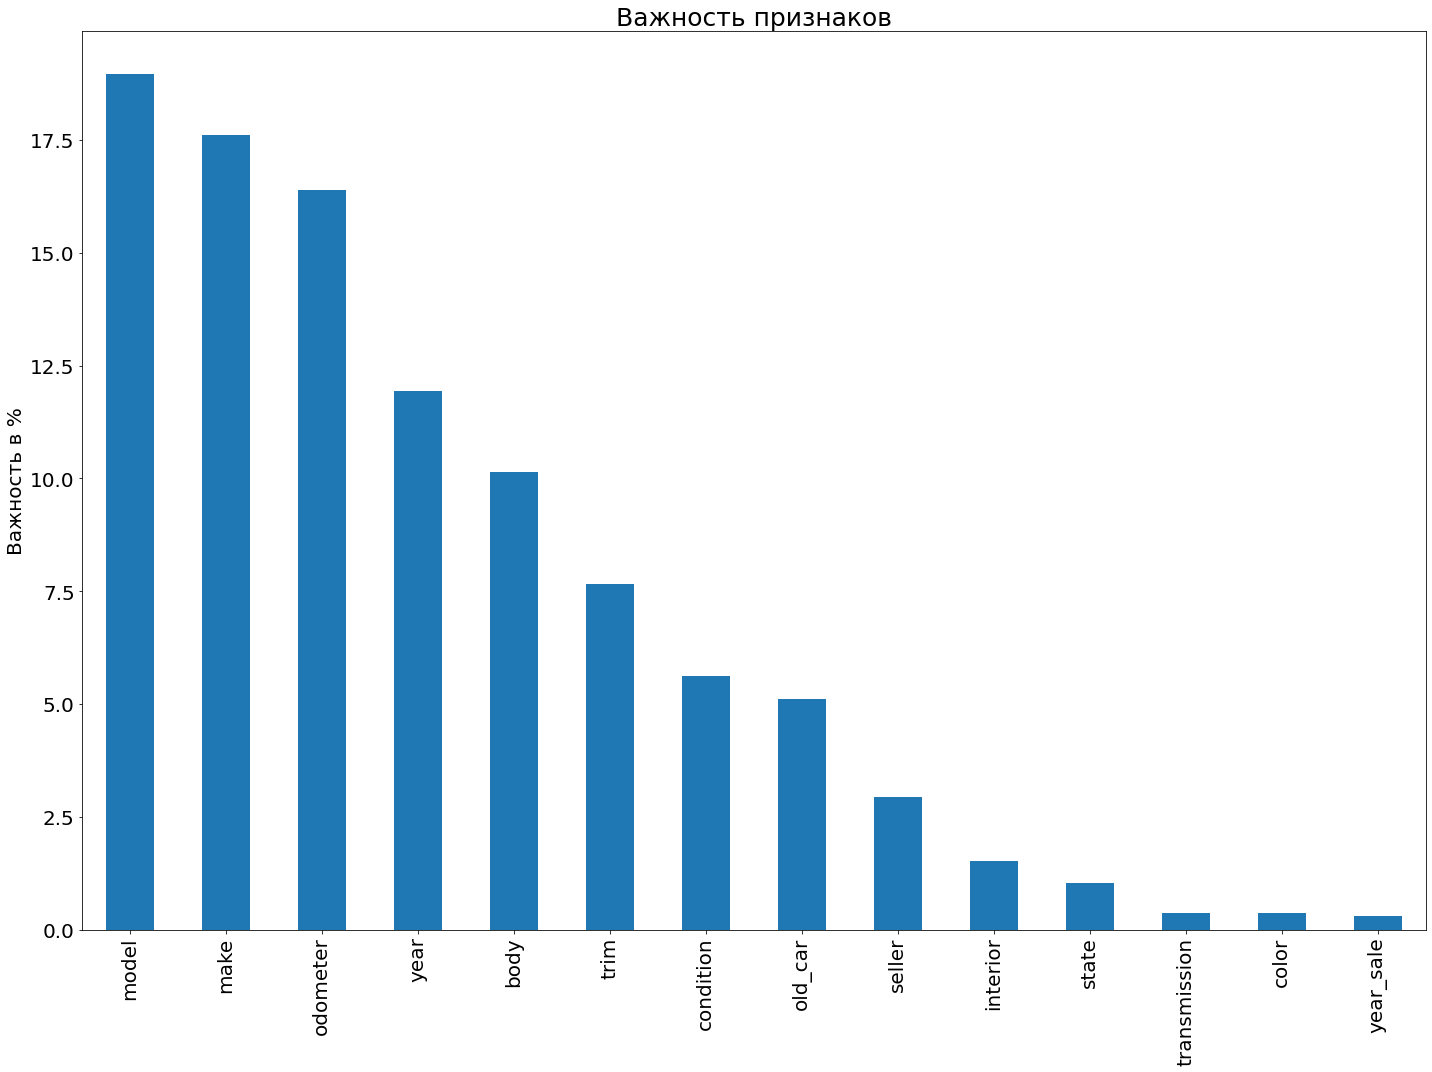

In [74]:
# выделим данные по признакам, для построения диаграммы, добавим сортировку для наглядности
diagram_data = pd.Series(model_regression.get_feature_importance(), train_features.columns).sort_values(ascending=False)
# определим размер диаграммы, построим саму диграмму
fig, ax = plt.subplots(figsize=(20, 15))
diagram_data.plot.bar(ax=ax, fontsize=20)
# зададим подписи: название диаграммы и название оси
ax.set_title('Важность признаков', fontsize=25)
ax.set_ylabel('Важность в %', fontsize=20)
fig.tight_layout()

***Как видно по диаграмме, имеем плавный нисходящий тренд, относительно важности признаков. Подобная картина может говорить нам, что в целом, все признаки так или иначе важны и вносят свой вклад для получения предсказаний модели. Самыми важными признаками являются: "модель", "марка", "пробег", "год производства" и "тип кузова".***

P.S.: Удивительно, что искуственный признак "возраст автомобиля" не входит в число самых значимых признаков, хотя по хорошему должен быть сопоставим с "годом производства". Также, хочется отметить, что выбор "типа коробки передач" находится в самом низу значимости, как и год продажи, учитывая что цена от года к году меняется странно (хотя возможно иммено эта неоднозначность и приводит к низкой значимости признака).

# Вывод

**Целью данного проекта является: разработка модели, которая будет предсказывать стоимость автомобилей на вторичном рынке.  В ходе выполнения проекта, была проделана следующая работа.**

1) Открыты и изучены файлы с данными. Подгружены необходимые библиотеки.

2) Была произведена предобработка данных.

* Удалён столбец, содержащий информацию о вин-номерах машин.
* Изучена стоимость автомобилей на обучающих данных. Выявлено, что имеются крайне низкие значения стоимости автомобилей, но избавлятся от них не стали, по причине отсутсвия информации о стоимости в тестовых данных.
* Проведена проверка данных на наличие пропусков. В ходе проверки отмечено, что пропуски есть почти везде. Были обработаны:
    - Категориальные поля ('make', 'model', 'trim', 'body', 'color', 'interior', 'transmission'). По причине невозможности их заполнить, была проведена замена на значение 'unknown'.
    - Числовые поля 'odometer' и 'condition' (пробег и состояние авто), заполняли медианными значениями по сгруппированным данным (год производства и модель автомобиля). Оставшиеся пропуски в поле "состояние авто" были заполнены медианными значениями по сгруппированным данным относительно года.
* Были дополнительно изучены поля "марка", "модель", "модификация" и "тип кузова". Было выявлено множество неявных дубликатов, различающихся регистром, и формой записи. Дубликаты в поле "марка" были устранены применением словаря (ручным способом). Остальные поля для экономии времени, были привидены к нижнему регистру, что позволило избавится от "львиной" доли неявных дубликатов.
* Поле "дата покупки", само по себе не нисет никого смысла, и во время кодирования внесёт только помеху. Исходя из этого, данный столбец был обработан, из него извлечена информация о том в какой год была произведена покупка машины, а также расчитан возраст автомобиля. В результате получены два столбца 'year_sale' и 'old_car'.

3) Произведён поиск лучшей модели на кросс-валидации с использованием библиотеки CatBoost. Так же, средства данного пакета позволили автоматически произвести кодирование категориальных признаков.

4) Разработана модель "линейной регрессии" с найдеными раннее параметрами. Проведена оценка качества на валидационных данных. Значение метрики R2 достигло 0.93, а значение метрики MAPE приблизилось к значению 0.17. Что может говорить, о том что разработанная модель в целом "неплоха".

5) Получен и сохранён в файл фрейм данных, содержащий информацию о вин-номере автомобилей и их предсказанную стоимость на тестовых данных.

6) В конце, проведена оценка значимости признаков. Самыми важными признаками стали: "модель", "марка", "пробег", "год производства" и "тип кузова". Признаки с самым низким показателем значимости: "тип КПП", "цвет" и "год продажи".

**В рамках дальнейшего развития и улучшения проекта, планируется улучшить предобработку данных. Изучить признак "вин-номер", который позволит заполнить большую часть пропущенных значений. Также, стоит по пробовать решить проблему нехватки памяти и разработать другие модели.**